In [889]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import math as math
from scipy.integrate import solve_ivp

## Energy Balance Reboiler

df_Me = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_methanol.xlsx')
df_Iso = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_isopropanol.xlsx')



In [890]:
# Getting data from file and making fitted line
Temp_list_Me = df_Me['Temperature'].values.tolist()
Cp_list_Me = df_Me['Cp'].values.tolist()
a_Me, b_Me, c_Me = np.polyfit(Temp_list_Me, Cp_list_Me, deg=2)

'''plt.plot(Temp_list_Me, Cp_list_Me, "o")
plt.plot(Temp_list_Me, np.polyval((a_Me, b_Me, c_Me),Temp_list_Me), "-")
plt.xlabel('T[K]')
plt.ylabel('Cp') 
plt.title('Methanol heat capacity')
plt.show()'''

# Heat Capacity Isopropanol

# Getting data and making fitted line
Temp_list_Iso = df_Iso['Temp'].values.tolist()
Cp_list_Iso = df_Iso['Cp'].values.tolist()
a_Iso, b_Iso, c_Iso = np.polyfit(Temp_list_Iso, Cp_list_Iso, deg=2)
Temps_Iso_model = np.linspace(-20, 85, 22)
Temps_Iso_model_K  = [x+273.15 for x in Temps_Iso_model] # convert to Kelvin

'''plt.plot(Temp_list_Iso, Cp_list_Iso, "o")
plt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")
plt.xlabel('T[K]') # label on the x axis
plt.ylabel('Cp') # label on the y axis
plt.title('Isopropanol heat capacity')
plt.show()'''

'plt.plot(Temp_list_Iso, Cp_list_Iso, "o")\nplt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")\nplt.xlabel(\'T[K]\') # label on the x axis\nplt.ylabel(\'Cp\') # label on the y axis\nplt.title(\'Isopropanol heat capacity\')\nplt.show()'

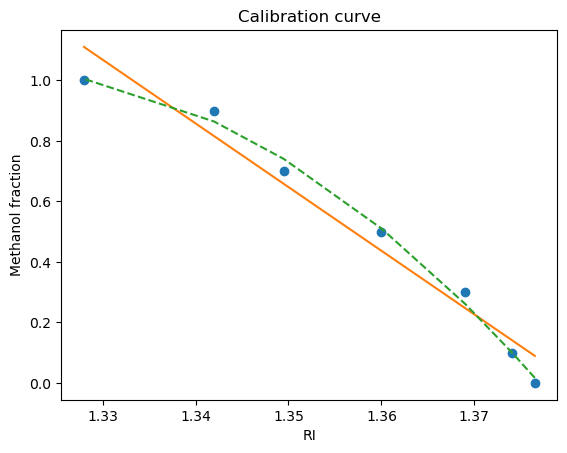

0.5105995532411498


In [891]:
# Refractive Index Calibration Curve

#Measurements
Me_fraction = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
RI = [1.3765, 1.374, 1.369, 1.360, 1.3495, 1.342, 1.328]

#fitting line at multiple degrees
Cal_a_fit, Cal_b_fit = np.polyfit(RI, Me_fraction, deg=1)
Cal_a_fit2, Cal_b_fit2, Cal_c_fit2 = np.polyfit(RI, Me_fraction, deg=2)

plt.plot(RI, Me_fraction,"o")
plt.plot(RI, np.polyval((Cal_a_fit, Cal_b_fit), RI),"-")
plt.plot(RI, np.polyval((Cal_a_fit2, Cal_b_fit2, Cal_c_fit2), RI), "--")
plt.xlabel("RI")
plt.ylabel("Methanol fraction")
plt.title('Calibration curve')
plt.show()

def Calibration(RI):
    Me_ratio = RI**2 * Cal_a_fit2 + RI*Cal_b_fit2 + Cal_c_fit2
    return Me_ratio

#use calibration function to get the methanol fraction
Me_frac = Calibration(1.36)
print(Me_frac)

In [892]:
# Constants
dH_vap_Me = 37340 #Enthalpy of vaporisation methanol at boiling point [J/mol]
dH_vap_iso = 44000 #Enthalpy of vaporisation isopropanol at boiling point [J/mol]
eff = 1 #640/751 # Heater efficiency (around 0.85)
T0 = 298 #K
V  = 0.01 # Volume of mixture in reboiler [m^3]
Iso_frac = 1-Me_frac # Mole fraction isopropanol
dens_Me = 792 #kg/m3
dens_Iso = 786 #kg/m3
M_Me = 32.02 #g/mol
M_Iso = 60.1 #g/mol
Vm_Me = 40.75 # molar volume methanol [cm^3/mol]
Vm = (M_Me/1000/dens_Me)*Me_frac + (M_Iso/1000/dens_Iso)*(1-Me_frac) # Molar volume of mixture [m^3/mol]
n_total = V/Vm # Total number of moles in mixture
n_Me = Me_frac*n_total # Number of moles of methanol
n_Iso = Iso_frac*n_total # Number of moles of isopropanol
dens_mix = (n_Me*M_Me + n_Iso*M_Iso)/V # Density of mixture [kg/m^3]
M_mix = (n_Me*M_Me + n_Iso*M_Iso)/1000 #kg/mol
power_percent = 0.7
power = eff*power_percent*2000 #J/s (maximum power is 2kW)
p_atm = 101325  # Atmospheric pressure in Pa
R = 8.3144598          # Gas constant J/molK
A = 1                  # Evaporation surface area m2
# Mass transfer coefficients




In [893]:
def Cp_Iso(T):
    Cp_Iso = a_Iso * T**2 + b_Iso*T + c_Iso
    return Cp_Iso

def Cp_Me(T):
    Cp_Me = a_Me * T**2 + b_Me * T + c_Me
    return Cp_Me

def Cp_mix(Me_frac,T):
    Cp_mix = Me_frac*Cp_Me(T) + (1-Me_frac)*Cp_Iso(T)
    return Cp_mix


# Vapor pressure for both compounds 
def p0_me(T):
    if T<288.1:
        p0_me=0
    elif (T>=288.1 and T<=353.5):
        #Antonie constants-methanol 
        A_me = 5.20409
        B_me = 1581.341
        C_me = -33.50
        #vapour pressure 
        anto_me = A_me - (B_me/(T+C_me))
        p0_me = (math.pow(10,anto_me)) * (1e5)   #Pa
    elif (T>353.5 and T<=512.63):
        #Antonie constants-methanol 
        A_me = 5.15853
        B_me = 1569.613
        C_me = -34.846
        #vapour pressure 
        anto_me = A_me - (B_me/(T+C_me))
        p0_me = (math.pow(10,anto_me)) * (1e5)   #Pa
    return p0_me   


def p0_iso(T):
    if T<329.92:
        p0_iso = 0
    elif (T>=329.92 and T<=362.41):
        #Antoine constants isopropanol
        A_iso = 4.8610
        B_iso =	1357.427
        C_iso = -75.814
        #vapour pressure 
        anto_iso = A_iso - (B_iso/(T+C_iso))
        p0_iso = (math.pow(10,anto_iso)) * (1e5)  #Pa
    elif (T>362.41 and T<=508.24):
        #Antoine constants isopropanol
        A_iso = 4.57795	
        B_iso =	1221.423
        C_iso = -87.474
        #vapour pressure 
        anto_iso = A_iso - (B_iso/(T+C_iso))
        p0_iso = (math.pow(10,anto_iso)) * (1e5)  #Pa

    return p0_iso


In [894]:
p0_me(293)

12891.112110361622

In [895]:
k_me = ((1.0020+1.2598)/2)*10**(-7) #m/s 
k_iso = ((2.47+3.17)/2)*10**(-10)   #m/s


In [896]:

params = {
    'Me_frac': Me_frac,   
    'n_total': n_total,
    'power': power,
    'A': A, 
    'R': R,        # Gas constant
    'k_me': k_me,  # mass coefficient methanol,
    'k_iso': k_iso, # mass coefficient isopropanol
    'p_atm': p_atm,
    'dH_vap_Me': dH_vap_Me
}

In [897]:
def modelODE(N,t,params):
    A = params['A']
    k_me = params['k_me']
    k_iso = params['k_iso']
    p_atm = params['p_atm']
    Me_frac = params['Me_frac']
    power = params['power']

    T_ref = 293.15 

    Nme_L = N[0]
    Niso_L = N[1]
    Nme_v = N[2]
    Niso_v = N[3]
    N_L_tot = Nme_L + Niso_L 
    N_v_tot = Nme_v + Niso_v
    N_tot = N_L_tot + N_v_tot
    T = N[4]
    
    #mol fractions 
    #y_me = Nme_v/(Niso_v+Nme_v)
    #x_me = Nme_L/(Nme_L+Niso_L)
    #y_iso = Niso_v/(Niso_v+Nme_v)
    #x_iso = Niso_L/(Nme_L+Niso_L)

    #y_me = Nme_v/(Nme_L+Nme_v)
    #x_me = Nme_L/(Nme_L+Nme_v)
    #y_iso = Niso_v/(Niso_v+Niso_L)
    #x_iso = Niso_L/(Niso_L+Niso_v)  

    y_me = Nme_v/(N_tot)
    x_me = Nme_L/(N_tot)
    y_iso = Niso_v/(N_tot)
    x_iso = Niso_L/(N_tot)
    
    dNdt = np.zeros(5)

    p_tot = y_me*p0_me(T) + y_iso*p0_iso(T)
    evap_me = 2*A*((x_me*p0_me(T) - p_tot*y_me)/(R*T))
    evap_iso = 0.2*A*((x_iso*p0_iso(T) - p_tot*y_iso)/(R*T))

    #if evap_iso<0:
        #evap_iso=0
    #if evap_me<0:
        #evap_me=0

    print(evap_me, evap_iso)

    dNdt[0] = -evap_me      #meL
    dNdt[1] = -evap_iso     #isoL
    dNdt[2] = evap_me       #meV
    dNdt[3] = evap_iso      #isoV
    dNdt[4] = (1/(Cp_mix(x_me,T)*(N_tot))) * (-(evap_me*dH_vap_Me) + (evap_iso*dH_vap_iso)) #temperature equation
    
    return dNdt

In [898]:
N_initial = [115, 115, 0.0001, 0.0001, 293] # meL isoL meV isoV
tspan = np.linspace(0, 100, 1000)
N = odeint(modelODE, N_initial, tspan, args = (params,))

5.291616347909869 -2.000609355958545e-13
5.291592337900627 -3.1437464390404165e-13
5.291592338006218 -3.1437412522260353e-13
5.291568328195252 -4.2868639108894407e-13
5.291568328300843 -4.2868587241590706e-13
5.284084483908817 -3.603544936147847e-11
5.284084477406848 -3.6035481859648674e-11
5.276619881753698 -7.15023560324582e-11
5.276619868813179 -7.150242062667952e-11
5.269174443949539 -1.06830081632019e-10
5.269174431071912 -1.0683014582893091e-10
5.2361008400350215 -2.631776646829201e-10
5.236100737560704 -2.63178172356153e-10
5.24479036926522 -2.2219231682581458e-10
5.2447903128055575 -2.2219259701449735e-10
5.220610741393685 -3.3607518500984174e-10
5.220610803583414 -3.3607487725291254e-10
5.196633436477477 -4.4849913211865207e-10
5.196633440910757 -4.48499109998601e-10
5.172855786313655 -5.594870918695739e-10
5.172855790680083 -5.594870701780939e-10
5.125890058092835 -7.772394317414986e-10
5.1258900783258206 -7.772393320786423e-10
5.0796949522814305 -9.894981185749916e-10
5.0796

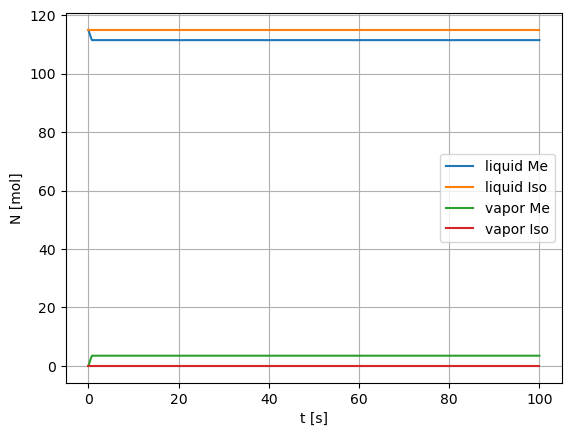

In [899]:
plt.plot(tspan, N[:,0], label = 'liquid Me')
plt.plot(tspan, N[:,1], label = 'liquid Iso')
plt.plot(tspan, N[:,2], label = 'vapor Me')
plt.plot(tspan, N[:,3], label = 'vapor Iso')
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("N [mol]")
plt.grid()
plt.show()

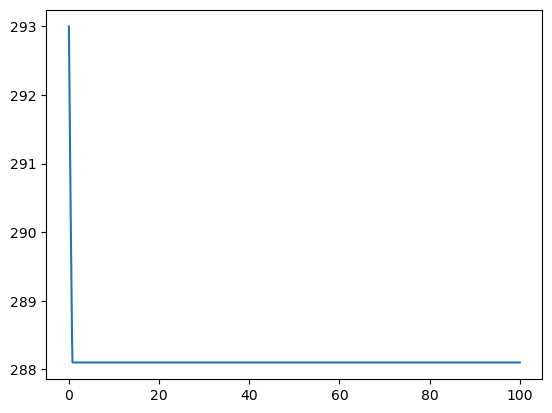

In [900]:
plt.plot(tspan,N[:,4])